# 1D regression showdown

In [317]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [3]:
import test_lofi
import test_ekf

In [4]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [356]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [325]:
# dataset = "kin8nm"
# train, test = datasets.load_uci_kin8nm()

In [387]:
# dataset = "wine"
# train, test = datasets.load_uci_wine_regression()

In [430]:
dataset = "naval"
train, test = datasets.load_uci_naval()

In [470]:
dataset = "power"
train, test = datasets.load_uci_power()

In [471]:
# train, test = datasets.load_1d_synthetic_dataset(5_000, 1_000, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [472]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean()
    }
    return res

## Test setup

In [473]:
key = jax.random.PRNGKey(314)

In [474]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

warmup_train = (X_warmup[:-100], y_warmup[:-100])
warmup_test = (X_warmup[-100:], y_warmup[-100:])

In [475]:
pbounds = {
    "log_init_cov": (-5, 1),
    "dynamics_weights": (1e-7, 1-1e-8),
    "log_emission_cov": (-7, -1e-6),
    "log_dynamics_cov": (-7, -1e-6),
}


## Model setup

In [476]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_train.shape
model = MLP(dim_out, activation=nn.elu)

# Agent showdown

## Diag-EKF

In [477]:
optimizer, apply_fn, n_params = test_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback
)

In [478]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.4262   | 0.9169    | -2.88     | -5.145    | -0.3008   |
| 2         | -0.4329   | 0.918     | -1.209    | -1.904    | -3.437    |
| 3         | -0.8345   | 0.9118    | -5.175    | -1.635    | -3.431    |
| 4         | -0.8323   | 0.1223    | -4.298    | -1.119    | -3.331    |
| 5         | -0.9379   | 0.06991   | -2.568    | -2.907    | -1.513    |
| 6         | -1.038    | 0.6772    | -2.19     | -3.928    | -3.074    |
| 7         | -0.8323   | 0.5706    | -3.641    | -0.9725   | 0.008828  |
| 8         | -0.8323   | 0.1058    | -6.577    | -2.822    | -0.2456   |
| 9         | -1.134    | 0.2264    | -3.254    | -6.048    | -2.767    |
| 10        | -0.8323   | 0.152     | -3.991    | -1.451    | -2.558    |
| 11        | -0.2818   | 1.0       | -2.868    | -5.29     | 0.5       |
| 12        | -0.2839   | 1.0       | 

In [479]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)

n_params = len(flat_params)
hparams = test_ekf.get_best_params(n_params, optimizer)
params_rebayes = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)

test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
dekf_estimator = ekf.RebayesEKF(params_rebayes, method="fdekf")
bel_dekf, output_dekf = dekf_estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## LoFi

In [480]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

optimizer, apply_fn, n_params = test_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method="lofi"
)

In [481]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.4869   | 0.9169    | -2.88     | -5.145    | -0.3008   |
| 2         | -1.519    | 0.918     | -1.209    | -1.904    | -3.437    |
| 3         | -0.8348   | 0.9118    | -5.175    | -1.635    | -3.431    |
| 4         | -0.833    | 0.1223    | -4.298    | -1.119    | -3.331    |
| 5         | -1.046    | 0.06991   | -2.568    | -2.907    | -1.513    |
| 6         | -0.8403   | 0.6772    | -2.19     | -3.928    | -3.074    |
| 7         | -0.9136   | 0.5706    | -3.641    | -0.9725   | 0.008828  |
| 8         | -1.129    | 0.1058    | -6.577    | -2.822    | -0.2456   |
| 9         | -1.15     | 0.2264    | -3.254    | -6.048    | -2.767    |
| 10        | -0.8413   | 0.152     | -3.991    | -1.451    | -2.558    |
| 11        | -0.2635   | 1.0       | -2.716    | -5.315    | 0.5293    |
| 12        | -0.2898   | 1.0       | 

In [482]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)
hparams = test_lofi.get_best_params(n_params, optimizer)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

lofi_estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn)
bel_lofi, output_lofi = lofi_estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## LoFi-aov

In [483]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

optimizer, apply_fn, n_params = test_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method="aov_lofi"
)

In [484]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.6038   | 0.9169    | -2.88     | -5.145    | -0.3008   |
| 2         | -0.8323   | 0.918     | -1.209    | -1.904    | -3.437    |
| 3         | -1.409    | 0.9118    | -5.175    | -1.635    | -3.431    |
| 4         | -0.8323   | 0.1223    | -4.298    | -1.119    | -3.331    |
| 5         | -0.837    | 0.06991   | -2.568    | -2.907    | -1.513    |
| 6         | -0.8323   | 0.6772    | -2.19     | -3.928    | -3.074    |
| 7         | -0.8442   | 0.5706    | -3.641    | -0.9725   | 0.008828  |
| 8         | -0.8794   | 0.1058    | -6.577    | -2.822    | -0.2456   |
| 9         | -0.8323   | 0.2264    | -3.254    | -6.048    | -2.767    |
| 10        | -0.8323   | 0.152     | -3.991    | -1.451    | -2.558    |
| 11        | -0.5395   | 0.9022    | -2.662    | -5.109    | -0.1393   |
| 12        | -0.8339   | 0.7592    | 

In [485]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)
hparams = test_lofi.get_best_params(n_params, optimizer)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

lofi_aov_estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method="aov_lofi")
bel_lofi_aov, output_lofi_aov = lofi_aov_estimator.scan(
    X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs
)

## LoFi full-svd

In [486]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

optimizer, apply_fn, n_params = test_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method="full_svd_lofi"
)

In [487]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.5185   | 0.9169    | -2.88     | -5.145    | -0.3008   |
| 2         | -0.8323   | 0.918     | -1.209    | -1.904    | -3.437    |
| 3         | -0.8323   | 0.9118    | -5.175    | -1.635    | -3.431    |
| 4         | -0.8323   | 0.1223    | -4.298    | -1.119    | -3.331    |
| 5         | -0.837    | 0.06991   | -2.568    | -2.907    | -1.513    |
| 6         | -0.8323   | 0.6772    | -2.19     | -3.928    | -3.074    |
| 7         | -0.8552   | 0.5706    | -3.641    | -0.9725   | 0.008828  |
| 8         | -0.8799   | 0.1058    | -6.577    | -2.822    | -0.2456   |
| 9         | -0.8323   | 0.2264    | -3.254    | -6.048    | -2.767    |
| 10        | -0.8323   | 0.152     | -3.991    | -1.451    | -2.558    |
| 11        | -0.2284   | 1.0       | -2.688    | -5.598    | 0.5074    |
| 12        | -10.0     | 1.0       | 

In [488]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)
hparams = test_lofi.get_best_params(n_params, optimizer)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

lofi_fsvd_estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method="full_svd_lofi")
bel_lofi_fsvd, output_lofi_fsvd = lofi_fsvd_estimator.scan(
    X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs
)

## FC-EKF

In [489]:
optimizer, apply_fn, n_params = test_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [490]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.3875   | 0.9169    | -2.88     | -5.145    | -0.3008   |
| 2         | -0.3952   | 0.918     | -1.209    | -1.904    | -3.437    |
| 3         | -0.8345   | 0.9118    | -5.175    | -1.635    | -3.431    |
| 4         | -0.8323   | 0.1223    | -4.298    | -1.119    | -3.331    |
| 5         | -0.9379   | 0.06991   | -2.568    | -2.907    | -1.513    |
| 6         | -1.038    | 0.6772    | -2.19     | -3.928    | -3.074    |
| 7         | -0.8323   | 0.5706    | -3.641    | -0.9725   | 0.008828  |
| 8         | -0.8323   | 0.1058    | -6.577    | -2.822    | -0.2456   |
| 9         | -1.134    | 0.2264    | -3.254    | -6.048    | -2.767    |
| 10        | -0.8323   | 0.152     | -3.991    | -1.451    | -2.558    |
| 11        | -0.3556   | 1.0       | -2.868    | -5.294    | 0.4861    |
| 12        | -0.3161   | 1.0       | 

In [491]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)

n_params = len(flat_params)
hparams = test_ekf.get_best_params(n_params, optimizer, method="fcekf")
params_rebayes = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)

test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
fcekf_estimator = ekf.RebayesEKF(params_rebayes, method="fcekf")
bel_fcekf, output_fcekf = fcekf_estimator.scan(
    X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs
)

## ORFit

In [492]:
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)
estimator_orfit = lofi.RebayesLoFi(params_orfit, params_lofi, method='orfit')
bel_orfit, output_orfit = estimator_orfit.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## Plot results

In [493]:
data = {
    "orfit": np.array(output_orfit["test"]),
    "lofi": np.array(output_lofi["test"]),
    "lofi-aov": np.array(output_lofi_aov["test"]),
    "lofi-fsvd": np.array(output_lofi_fsvd["test"]),
    "dekf": np.array(output_dekf["test"]),
    "fcekf": np.array(output_fcekf["test"])
}

data = pd.DataFrame(data)

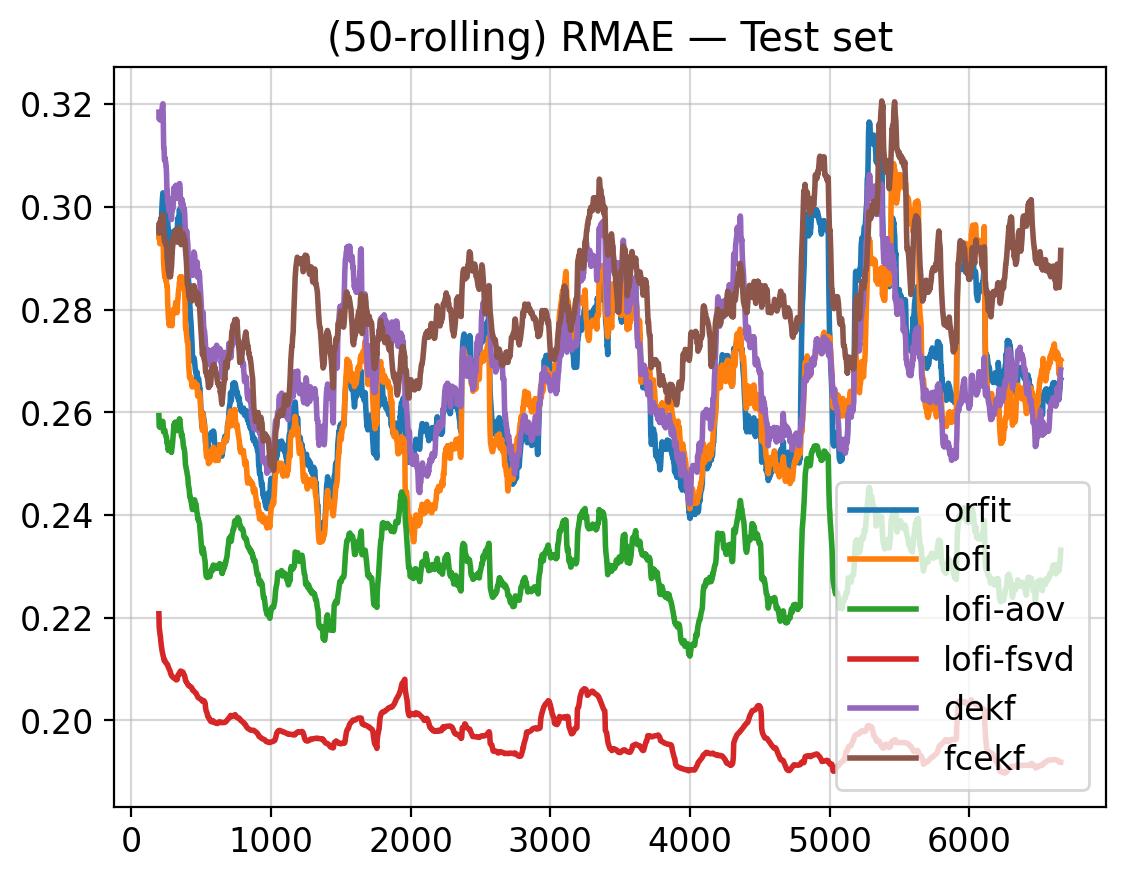

In [494]:
data.rolling(200).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

In [495]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_init, key_shuffle = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=rmae_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [496]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [497]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

In [498]:
%%time
data_lofi = eval_runs(key, num_runs_pc=5, estimator=lofi_estimator)
data_lofi = pd.DataFrame(data_lofi["test"]).T

CPU times: user 11.2 s, sys: 444 ms, total: 11.7 s
Wall time: 7.31 s


In [499]:
%%time
data_lofi_aov = eval_runs(key, num_runs_pc=5, estimator=lofi_aov_estimator)
data_lofi_aov = pd.DataFrame(data_lofi_aov["test"]).T

CPU times: user 11.5 s, sys: 138 ms, total: 11.6 s
Wall time: 7.37 s


In [500]:
%%time
data_lofi_fsvd = eval_runs(key, num_runs_pc=5, estimator=lofi_fsvd_estimator)
data_lofi_fsvd = pd.DataFrame(data_lofi_fsvd["test"]).T

CPU times: user 15.9 s, sys: 506 ms, total: 16.4 s
Wall time: 25.8 s


In [501]:
%%time
data_orfit = eval_runs(key, num_runs_pc=5, estimator=estimator_orfit)
data_orfit = pd.DataFrame(data_orfit["test"]).T

CPU times: user 9.85 s, sys: 202 ms, total: 10.1 s
Wall time: 6.3 s


In [502]:
%%time
data_fdekf = eval_runs(key, num_runs_pc=5, estimator=dekf_estimator)
data_fdekf = pd.DataFrame(data_fdekf["test"]).T

CPU times: user 10.3 s, sys: 213 ms, total: 10.5 s
Wall time: 7.12 s


In [503]:
%%time
data_fcekf = eval_runs(key, num_runs_pc=5, estimator=fcekf_estimator)
data_fcekf = pd.DataFrame(data_fcekf["test"]).T

CPU times: user 16.9 s, sys: 440 ms, total: 17.3 s
Wall time: 13.3 s


In [504]:
colors = {
    "lofi": "tab:blue",
    "lofi-aov": "tab:orange",
    "orfit": "tab:green",
    "fd-ekf": "tab:purple",
    "fc-ekf": "tab:gray",
    "lofi-fsvd": "tab:red",
}

In [505]:
collection = {
    "lofi": data_lofi,
    "lofi-aov": data_lofi_aov,
    "lofi-fsvd": data_lofi_fsvd,
    "orfit": data_orfit,
    "fd-ekf": data_fdekf,
    "fc-ekf": data_fcekf
}

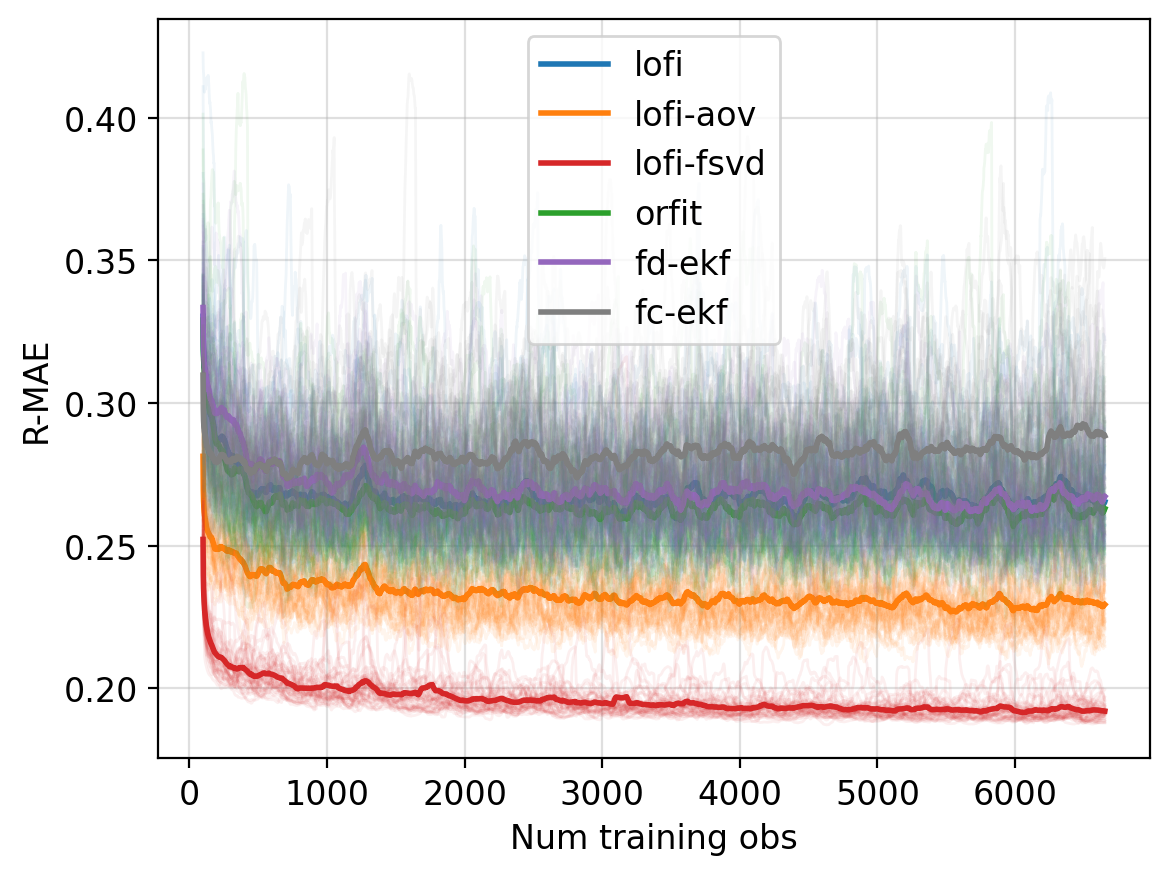

In [506]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

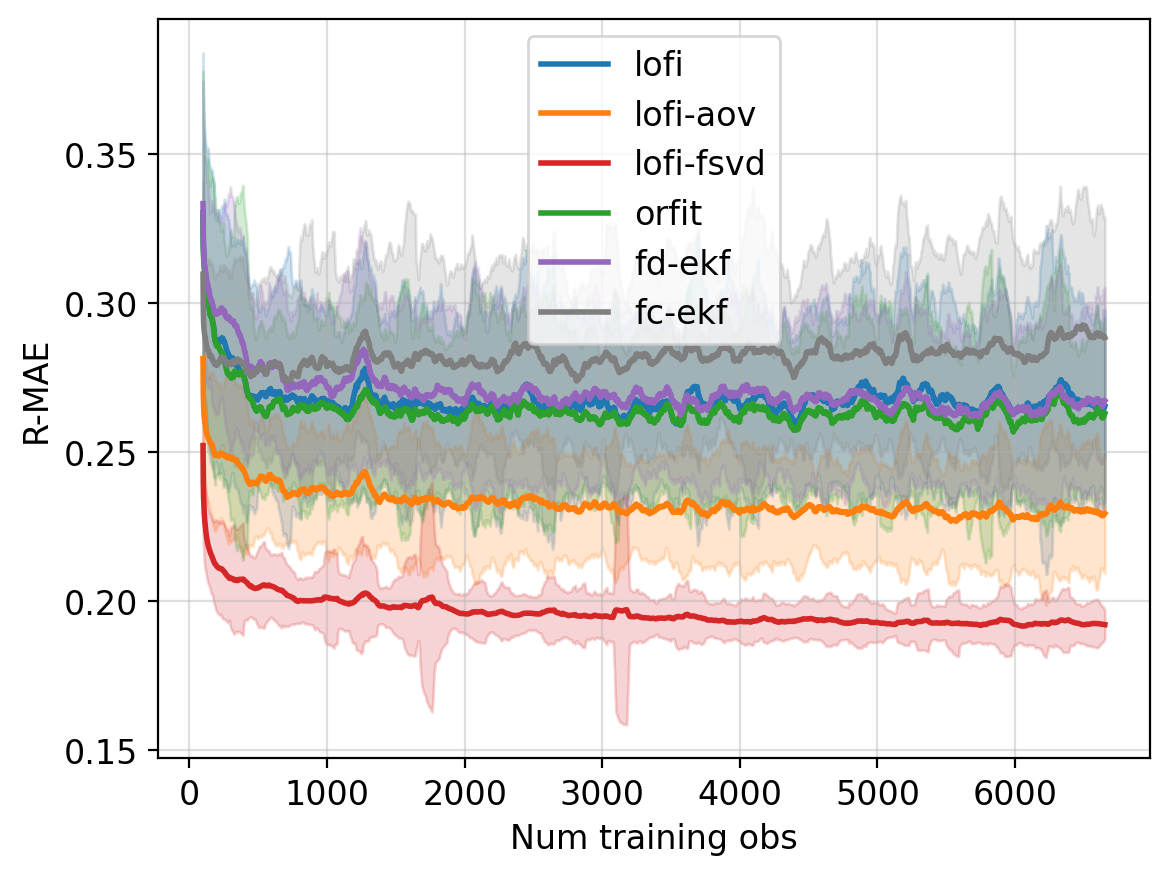

In [507]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

In [508]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

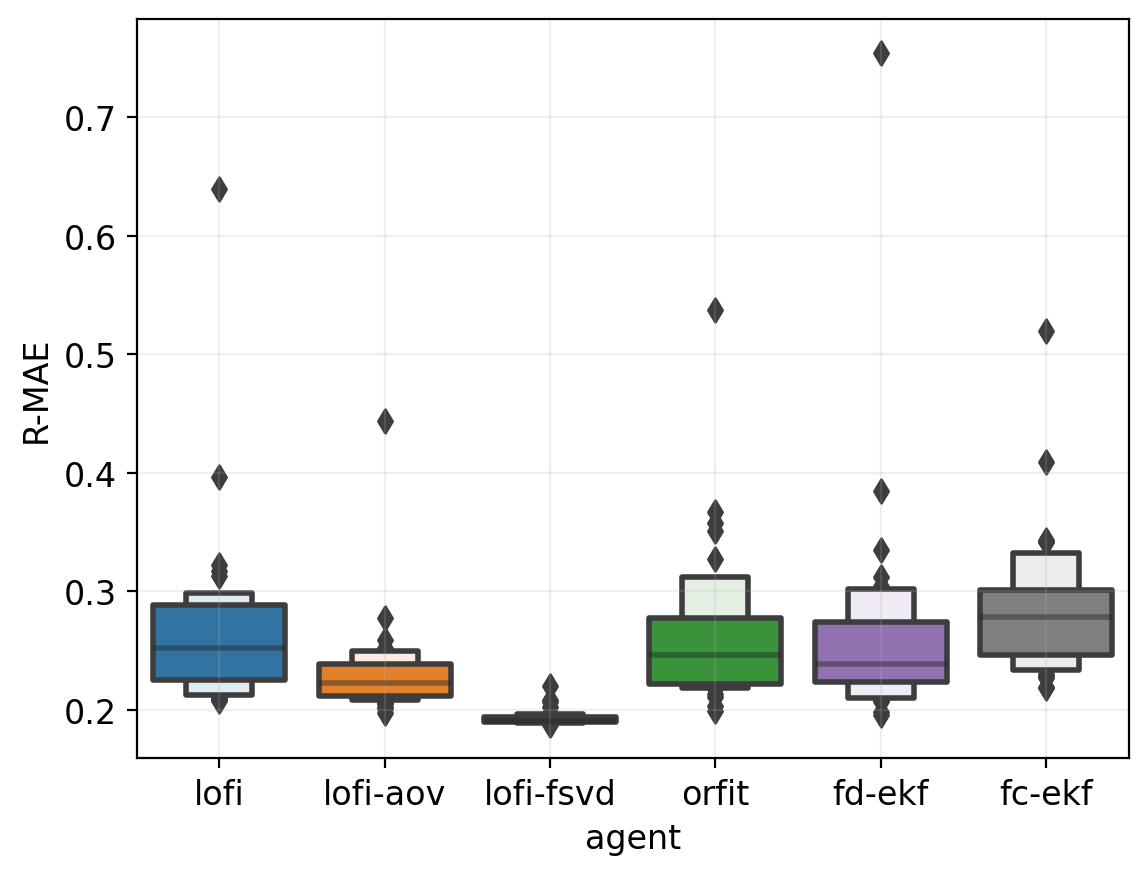

In [509]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")